## Environment Set up

### Colab to Delete

In [ ]:
# Put your input and output paths here:

inputPath = ''
outputPath = ''

In [ ]:
# Uncomment this if running on Google Colab to install Latex:

# !git clone https://github.com/latex3/latex2e.git

# !apt-get update
# !sudo apt-get install texlive-full 

In [ ]:
# Uncomment this if running on Google Colab to install Latex:

# !pip install latex
# import latex

### Global Settings

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np

# Latex Configuration
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
from collections import defaultdict

from scipy.stats import chi2_contingency

params = {
    "axes.titlesize" : 25,
    'axes.labelsize': 20,
    'font.size': 15,
    'legend.fontsize': 20,
    'xtick.labelsize': 15,
    'ytick.labelsize': 20,
    'font.family': 'serif',
    'text.usetex': True
}

mpl.rcParams.update(params)

In [3]:
TIMEFORMAT = "%Y-%m-%d %H:%M:%S"

In [4]:
Q_emergence = datetime.date(2017, 10, 28)
Q_ban = datetime.date(2018, 9, 12)

In [5]:
time_delta = Q_ban - Q_emergence

In [6]:
time_delta

datetime.timedelta(days=319)

In [7]:
colors = [
    "#72a555",
    "#ab62c0",
    "#c57c3c",
    "#638ccc",
    "#ca5670"
]

## Import and Format Input Files

### Reddit submissions

In [8]:
sub_df = pd.read_csv(inputPath + "Hashed_Q_Submissions_Raw_Combined.csv", lineterminator='\n')
sub_df = sub_df.drop(columns=["upvote_ratio"]).drop_duplicates()
sub_df.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(2099875, 12)

In [9]:
sub_df.columns

Index(['subreddit', 'id', 'score', 'numReplies', 'author', 'title', 'text',
       'is_self', 'domain', 'url', 'permalink', 'date_created'],
      dtype='object')

In [10]:
sub_df['date_created'] = pd.to_datetime(sub_df['date_created'])

In [11]:
sub_df['type'] = 'submission'

### Reddit Comments

In [12]:
comments_df = pd.read_csv(inputPath + "Hashed_Q_Comments_Raw_Combined.csv", lineterminator='\n')
print("Before dropping duplicated ID:", len(comments_df))
comments_df = comments_df.drop(columns=["score"]).drop_duplicates()
print("After dropping duplicated ID:", len(comments_df))

Before dropping duplicated ID: 10832349
After dropping duplicated ID: 10831922


In [13]:
comments_df.columns

Index(['id', 'link_id', 'parent_id', 'author', 'subreddit', 'body',
       'date_created'],
      dtype='object')

In [14]:
comments_df['date_created'] = pd.to_datetime(comments_df['date_created'])

In [15]:
len(comments_df[~pd.isnull(comments_df['id'])])

10831922

In [16]:
comments_df['type'] = 'comment'

### Combined submission and comment activity

In [17]:
all_df = pd.concat([sub_df, comments_df])

In [18]:
print(all_df.shape, all_df.author.nunique(), 'authors', all_df.subreddit.nunique(), 'subreddits')

(12931797, 16) 13182 authors 63697 subreddits


In [19]:
all_df.head(3)

,subreddit,id,score,numReplies,author,title,text,is_self,domain,url,permalink,date_created,type,link_id,parent_id,body
0,greatawakening,8xuv4i,1.0,14.0,879f283b831c13474e219e88663d95b0763cca9b,I’ve been writing “Trump Lives Here” on my $20...,NaN,False,i.redd.it,https://i.redd.it/h3mbbxvxq7911.jpg,/r/greatawakening/comments/8xuv4i/ive_been_wri...,2018-07-11 00:27:24,submission,NaN,NaN,NaN
1,greatawakening,8ydw3e,1.0,13.0,879f283b831c13474e219e88663d95b0763cca9b,Trying to take him seriously but...,NaN,False,i.redd.it,https://i.redd.it/62gaw0th4l911.jpg,/r/greatawakening/comments/8ydw3e/trying_to_ta...,2018-07-12 21:26:32,submission,NaN,NaN,NaN
2,greatawakening,8ytwg0,1.0,0.0,879f283b831c13474e219e88663d95b0763cca9b,“It is all happening!” Crumb?,NaN,False,i.redd.it,https://i.redd.it/yo9zscb1jx911.jpg,/r/greatawakening/comments/8ytwg0/it_is_all_ha...,2018-07-14 15:09:25,submission,NaN,NaN,NaN


### Q-user authors

In [20]:
author_status = pd.read_csv(inputPath + "Hashed_allAuthorStatus.csv", index_col=0)
author_status.reset_index(inplace=True)

In [21]:
author_status.columns

Index(['QAuthor', 'isUQ', 'status'], dtype='object')

In [22]:
author_status.head(5)

,QAuthor,isUQ,status
0,aa65b7dd5d5fa660d058e094669f884bf7d52299,0,Active
1,2b1505f289338751829dfa129c0b52d145c9eceb,1,Active
2,4eeddb9abeb3c4889f1b037016bf2aeb834bb66d,0,Active
3,08a6fae5a56fcdb495b2de8a02625ea2b4abe32f,1,Active
4,01301652214982c57efe894efe7e2c7d57df2801,0,Active


In [23]:
print(author_status.QAuthor.nunique(), 'authors', author_status[author_status['isUQ'] == 1].QAuthor.nunique(), 'Q-enthusiastic', author_status[author_status['isUQ'] == 0].QAuthor.nunique(), 'Q-interested')

13182 authors 3506 Q-enthusiastic 9676 Q-interested


In [24]:
author_status.status.value_counts()

Active          11014
DNE              1624
Is_suspended      544
Name: status, dtype: int64

In [25]:
the_donald_submissions = sub_df[sub_df["subreddit"]=="The_Donald"]
the_donald_users = set(the_donald_submissions.author.unique().tolist())

q_enth = set(author_status[author_status["isUQ"]==1]["QAuthor"].tolist())

len(the_donald_users.intersection(q_enth)) / len(q_enth)

0.4150028522532801

In [26]:
the_donald_submissions = all_df[all_df["subreddit"]=="The_Donald"]
the_donald_users = set(the_donald_submissions.author.unique().tolist())

q_enth = set(author_status[author_status["isUQ"]==1]["QAuthor"].tolist())

len(the_donald_users.intersection(q_enth)) / len(q_enth)

0.5581859669138619

### Active subreddit statistics

In [27]:
subreddit_stat = pd.read_csv(inputPath + "Hashed_subredditStats.csv")

In [28]:
subreddit_stat.columns

Index(['subreddit', 'numSubscribers', 'status', 'allModNames', 'allMods',
       'qModNames', 'qMods', 'top_qModNames', 'top_qMods',
       'firstPostSubmission', 'lastPostSubmission', 'firstPostComment',
       'lastPostComment', 'qModsRatio', 'top_qModsRatio', 'activePreBanOnly',
       'activePreQ', 'activePostBan', 'qAuth', 'top_qAuth', 'qSubmissions',
       'top_qSubmissions', 'nonTop_qSubmissions', 'qComments', 'top_qComments',
       'nonTop_qComments', 'top_qPercent', 'qPercent',
       'Monthly Average Total Authors', 'Monthly Average Total Submissions',
       'Monthly Average UQ Authors', 'Monthly Average UQ Submissions',
       'Monthly Average QAnon Authors', 'Monthly Average QAnon Submissions',
       '% UQ Submissions', '% UQ Authors', '% QAnon Submissions',
       '% QAnon Authors'],
      dtype='object')

### Subreddit Labels (Mapping Topic and Relation Labels to Subreddits)

In [29]:
subreddit_label_df = pd.read_csv(inputPath + "Subreddit_Cluster_Map.csv", index_col=0)

In [30]:
subreddit_label_df.columns

Index(['subreddit', 'Codes', 'Final Topic Clusters',
       'Final Relation Clusters'],
      dtype='object')

## ACTIVITY PATTERNS OF Q-USERS

### Utils and Processing

In [31]:
def paint_bar_plot(bars, seqs, labels, title, filename):
  height = [[] for s in seqs]
  before = 0
  cnted = 0
  bar_names = []
  color = []

  for ind, b in enumerate(bars[::-1]):
    for seqind, seq in enumerate(seqs):
      cnt = 0
      for s in seq:
        if (ind == 0 or s > 1. / float(before)) and (s <= 1. / float(b)):
            cnt += 1
      height[seqind].append(cnt)
    if ind == 0:
        bar_names.append(r'$[0, \frac{1}{' + str(b) + '}]$')
    else:
      bar_names.append(r'$(\frac{1}{' + str(before) + '},$' + r'$\frac{1}{' + str(b) + '}]$')
    before = b
    color.append(colors[0])
    
  color.append(colors[1])
  cnt = 0.
  for seqind, seq in enumerate(seqs):
    cnt = 0
    for s in seq:
      if (s > 1. / float(bars[0])) and (s < float(bars[0])):
        cnt += 1  
    height[seqind].append(cnt)
  bar_names.append(r'$(\frac{1}{' + str(bars[0]) + '}, ' + str(bars[0]) + ')$')


  before = bars[0]
  for ind, b in enumerate(bars):
    for seqind, seq in enumerate(seqs):
      cnt = 0
      for s in seq:
        if (s >= b) and (ind == len(bars)-1 or (s < bars[ind+1])):
            cnt += 1
      height[seqind].append(cnt)
    if ind == len(bars)-1:
        bar_names.append(r'$[' + str(b) + ', \inf)$')
    else:
      bar_names.append(r'$[' + str(b)+ ', ' + str(bars[ind+1]) + ')$'.format(b, bars[ind+1]))
    color.append(colors[2])  
  #error = [2.65, 7.27, 7.07, 5.91, 6.11, 12.8]
  print(chi2_contingency(height))
  height = [[h / float(len(seqs[ind])) for h in hh] for ind, hh in enumerate(height)]
  y_pos = np.arange(len(bar_names))

  return height, y_pos, bar_names

In [32]:
# Q-user's first and last post (including submissions and comments)
all_df['date_created'] = pd.to_datetime(all_df['date_created'])

authFirstPost = all_df.groupby('author')[['date_created']].min().reset_index()
authFirstPost.rename(columns={"date_created": "first_post", "author":"QAuthor"},inplace=True)
author_status = author_status.merge(authFirstPost, on="QAuthor", how="left")

authLastPost = all_df.groupby('author')[['date_created']].max().reset_index()
authLastPost.rename(columns={"date_created": "last_post", "author":"QAuthor"},inplace=True)
author_status = author_status.merge(authLastPost, on="QAuthor", how="left")

In [33]:
author_status["active_pre_emergence"] = author_status.apply(lambda row: row.first_post < Q_emergence, axis=1)
author_status["active_post_ban"] = author_status.apply(lambda row: row.last_post > Q_ban, axis=1)
Q_intr_df = author_status[author_status["isUQ"]==0]
Q_enth_df = author_status[author_status["isUQ"]==1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  


### Table 1

In [34]:
def get_status_count(input_df):
    return [
        input_df.count()[0], \
        input_df[input_df["status"]=="Active"].count()[0], \
        input_df[input_df["status"]=="DNE"].count()[0], \
        input_df[input_df["status"]=="Is_suspended"].count()[0], \
        input_df[(input_df["status"]=="Active") & (input_df["active_pre_emergence"])].count()[0], \
        input_df[(input_df["status"]=="Active") & (input_df["active_post_ban"])].count()[0],
    ]

results = [get_status_count(Q_intr_df), get_status_count(Q_enth_df)]
results

[[9676, 8081, 1156, 439, 2702, 4611], [3506, 2933, 468, 105, 855, 1951]]

### Fig. 1 Q-users are more active in the Q period

In [ ]:
all_df['phase_1'] = all_df.apply(lambda x: (x['date_created'] < Q_emergence) and
                                (x['date_created'] >= Q_emergence - time_delta), axis = 1)
all_df['phase_2'] = all_df.apply(lambda x: (x['date_created'] >= Q_emergence) and
                                (x['date_created'] <= Q_ban), axis = 1)


In [ ]:
all_df['phase_3'] = all_df.apply(lambda x: (x['date_created'] > Q_ban) and
                                 (x['date_created'] <= Q_ban + time_delta), axis = 1)
all_df['phase_4'] = all_df.apply(lambda x: (x['date_created'] > Q_ban + time_delta) and
                                 (x['date_created'] <= Q_ban + 2*time_delta), axis = 1)

In [ ]:
qauth_activity = pd.merge(all_df[['phase_1', 'phase_2', 'phase_3', 'phase_4', 'author']],
                          author_status, left_on=['author'], right_on=['QAuthor'], how='inner')

In [ ]:
qauth_activity

,phase_1,phase_2,phase_3,phase_4,author,QAuthor,isUQ,status,first_post,last_post,active_pre_emergence,active_post_ban
0,False,True,False,False,879f283b831c13474e219e88663d95b0763cca9b,879f283b831c13474e219e88663d95b0763cca9b,1,Active,2018-06-16 03:31:58,2020-10-18 12:54:46,False,True
1,False,True,False,False,879f283b831c13474e219e88663d95b0763cca9b,879f283b831c13474e219e88663d95b0763cca9b,1,Active,2018-06-16 03:31:58,2020-10-18 12:54:46,False,True
2,False,True,False,False,879f283b831c13474e219e88663d95b0763cca9b,879f283b831c13474e219e88663d95b0763cca9b,1,Active,2018-06-16 03:31:58,2020-10-18 12:54:46,False,True
3,False,True,False,False,879f283b831c13474e219e88663d95b0763cca9b,879f283b831c13474e219e88663d95b0763cca9b,1,Active,2018-06-16 03:31:58,2020-10-18 12:54:46,False,True
4,False,True,False,False,879f283b831c13474e219e88663d95b0763cca9b,879f283b831c13474e219e88663d95b0763cca9b,1,Active,2018-06-16 03:31:58,2020-10-18 12:54:46,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
12931792,False,False,False,True,c039f11ff985f7d8547748c10ccd5c8416b8404d,c039f11ff985f7d8547748c10ccd5c8416b8404d,1,Is_suspended,2017-01-09 00:19:12,2019-11-05 21:55:07,True,True
12931793,False,False,False,True,c039f11ff985f7d8547748c10ccd5c8416b8404d,c039f11ff985f7d8547748c10ccd5c8416b8404d,1,Is_suspended,2017-01-09 00:19:12,2019-11-05 21:55:07,True,True
12931794,False,False,False,True,c039f11ff985f7d8547748c10ccd5c8416b8404d,c039f11ff985f7d8547748c10ccd5c8416b8404d,1,Is_suspended,2017-01-09 00:19:12,2019-11-05 21:55:07,True,True
12931795,False,False,False,True,c039f11ff985f7d8547748c10ccd5c8416b8404d,c039f11ff985f7d8547748c10ccd5c8416b8404d,1,Is_suspended,2017-01-09 00:19:12,2019-11-05 21:55:07,True,True


In [ ]:
auth_stats = qauth_activity[qauth_activity['phase_1']].groupby('author').size().reset_index(name='phase_1_cnt')
tmp = qauth_activity[qauth_activity['phase_2']].groupby('author').size().reset_index(name='phase_2_cnt')
auth_stats = pd.merge(auth_stats, tmp, on='author', how='outer')
tmp = qauth_activity[qauth_activity['phase_3']].groupby('author').size().reset_index(name='phase_3_cnt')
auth_stats = pd.merge(auth_stats, tmp, on='author', how='outer')
tmp = qauth_activity[qauth_activity['phase_4']].groupby('author').size().reset_index(name='phase_4_cnt')
auth_stats = pd.merge(auth_stats, tmp, on='author', how='outer')
auth_stats = auth_stats.fillna(0)

In [ ]:
auth_stats = auth_stats[auth_stats['phase_2_cnt'] >= 5]

In [ ]:
len(auth_stats)

10354

In [ ]:
auth_stats['phase1_to_phase2'] = auth_stats.apply(lambda x: x['phase_1_cnt'] / x['phase_2_cnt'], axis=1)
auth_stats['phase3_to_phase2'] = auth_stats.apply(lambda x: x['phase_3_cnt'] / x['phase_2_cnt'], axis=1)
auth_stats['phase4_to_phase2'] = auth_stats.apply(lambda x: x['phase_4_cnt'] / x['phase_2_cnt'], axis=1)

In [ ]:
auth_stats = pd.merge(auth_stats, author_status, left_on='author', right_on='QAuthor', how='left')

In [ ]:
auth_stats['status'].unique()

array(['Active', 'DNE', 'Is_suspended'], dtype=object)

In [ ]:
active_users = auth_stats['author'].values

In [ ]:
auth_stats = auth_stats[auth_stats['status'] == 'Active']

In [ ]:
len(author_status[(author_status.QAuthor.isin(active_users)) & (author_status['isUQ'] == 0)]) / len(author_status[author_status['isUQ'] == 0])

0.7077304671351798

In [ ]:
author_status.groupby('status').size()

status
Active          11014
DNE              1624
Is_suspended      544
dtype: int64

In [ ]:
author_status[author_status['isUQ']==0].groupby('status').size()

status
Active          8081
DNE             1156
Is_suspended     439
dtype: int64

In [ ]:
author_status[(author_status['isUQ']==1) & (author_status.QAuthor.isin(active_users))].groupby('status').size()

status
Active          2933
DNE              468
Is_suspended     105
dtype: int64

In [ ]:
def calculate_cdf(input_ratios):
    cdf = np.arange(1, len(input_ratios)+1) / len(input_ratios)
    return cdf

In [ ]:
def get_cdf(input_df, input_col):                       
    enth_cdf = input_df[input_df["isUQ"]==1][[input_col]].sort_values(by=input_col).copy()
    enth_cdf['cdf'] = calculate_cdf(enth_cdf[input_col])
    enth_cdf

    intr_cdf = input_df[input_df["isUQ"]==0][[input_col]].sort_values(by=input_col).copy()
    intr_cdf['cdf'] = calculate_cdf(intr_cdf[input_col])
    intr_cdf

    return enth_cdf, intr_cdf

In [ ]:
import matplotlib.ticker as mticker

def paint_line_graph_log_zero_adjusted(enth, intr, ax, col, title, ifLegend):
    enth_adjusted = enth[col].values + 0.00001
    ax.plot(enth_adjusted, enth['cdf'].values, color="#ab62c0", linestyle="--", alpha=0.9, linewidth=4, label="QAnon-enthusiastic users", zorder=2)
    intr_adjusted = intr[col].values + 0.00001
    ax.plot(intr_adjusted, intr['cdf'].values, color="#ab62c0", linestyle="-", alpha=0.45, linewidth=4, label="QAnon-interested users", zorder=2)
    
    ax.grid(color="#d3d3d3", ls=":")
    if ifLegend: 
        ax.legend(loc=2, prop={'size': 18})
    ax.set_title(title)
    ax.set_xscale('log')
    ax.set_xticks([0.00001, 0.00011, 0.00101, 0.01001, 0.10001, 1.00001, 10.00001, 100.00001, 1000.00001, 10000.0001])
    vals = ax.get_xticks()
    f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
    ax.set_xticklabels(["${}$".format(f._formatSciNotation('%1.10e' % x)) for x in [0, 0.0001, 0.001, 0.01, 0.1, 1, 10., 100, 1000, 10000]])
    return ax

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


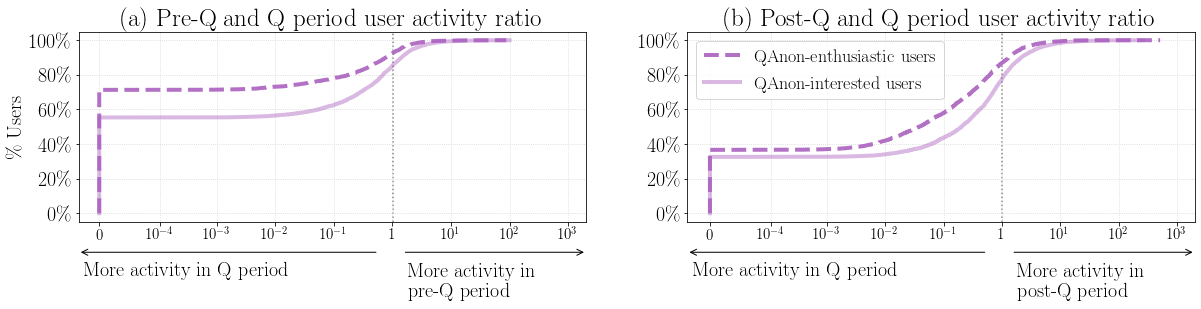

In [ ]:
fig, axs = plt.subplots(1, 2)

ax1, ax2 = axs[0], axs[1]

enth_preQ, intr_preQ = get_cdf(auth_stats, "phase1_to_phase2")
ax1.axvline(x=1.01, color="#838383", ls=":", zorder=0)
ax1 = paint_line_graph_log_zero_adjusted(enth_preQ, intr_preQ, ax1, "phase1_to_phase2", "(a) Pre-Q and Q period user activity ratio", False)
ax1.annotate('', xy=(0, -0.16), xycoords='axes fraction', xytext=(0.59, -0.16),
            arrowprops=dict(arrowstyle="->", color='black'))
ax1.annotate("More activity in Q period", xy=(0.01, -0.29), xycoords = 'axes fraction', fontsize=20)
ax1.annotate('', xy=(0.64, -0.16), xycoords='axes fraction', xytext=(1, -0.16), 
            arrowprops=dict(arrowstyle="<-", color='black'))
ax1.annotate("More activity in", xy=(0.65, -0.29), xycoords='axes fraction', fontsize=20)
ax1.annotate("pre-Q period", xy=(0.65, -0.4), xycoords='axes fraction', fontsize=20)
ax1.set_ylabel('\% Users')
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
vals = ax1.get_yticks()
ax1.set_yticklabels(['${:d}\%$'.format(int(x * 100)) for x in vals])

ax2.axvline(x=1.01, color="#838383", ls=":", zorder=0)
enth_postQ, intr_postQ = get_cdf(auth_stats, "phase3_to_phase2")
ax2 = paint_line_graph_log_zero_adjusted(enth_postQ, intr_postQ, ax2, "phase3_to_phase2", "(b) Post-Q and Q period user activity ratio", True)

ax2.annotate('', xy=(0, -0.16), xycoords='axes fraction', xytext=(0.59, -0.16),
            arrowprops=dict(arrowstyle="->", color='black'))
ax2.annotate("More activity in Q period", xy=(0.01, -0.29), xycoords='axes fraction', fontsize=20)
ax2.annotate('', xy=(0.64, -0.16), xycoords='axes fraction', xytext=(1, -0.16), 
            arrowprops=dict(arrowstyle="<-", color='black'))
ax2.annotate("More activity in", xy=(0.65, -0.29), xycoords='axes fraction', fontsize=20)
ax2.annotate("post-Q period", xy=(0.65, -0.4), xycoords='axes fraction', fontsize=20)
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
vals = ax2.get_yticks()
ax2.set_yticklabels(['${:d}\%$'.format(int(x * 100)) for x in vals])

for ax in axs:
    ax.xaxis.grid(color="#d3d3d3", ls=":")
    ax.yaxis.grid(color="#d3d3d3", ls=":")
    ax.set_xlim(0, 2000)

fig.set_figwidth(20)
fig.set_figheight(3.5)
fig.savefig(outputPath + 'figs/user_activity_start_0.pdf', bbox_inches = 'tight')
fig.show()

In [ ]:
len(enth_preQ[enth_preQ["phase1_to_phase2"]==0.0]) / len(enth_preQ)

0.7129219229457893

In [ ]:
len(intr_preQ[intr_preQ["phase1_to_phase2"]==0.0]) / len(intr_preQ)

0.5534135125574814

In [ ]:
len(enth_postQ[enth_postQ["phase3_to_phase2"]==0.0]) / len(enth_postQ)

0.3661779747698602

In [ ]:
len(intr_postQ[intr_postQ["phase3_to_phase2"]==0.0]) / len(intr_postQ)

0.3256101874778918

## CHARACTERIZING USER SPREAD

### Utils and Processing

In [ ]:

def paint_bar_plot2(bars, seqs):
  height = [[] for s in seqs]
  before = -1
  cnted = 0
  bar_names = []
  color = []

  for ind, b in enumerate(bars):
    for seqind, seq in enumerate(seqs):
      cnt = 0
      for s in seq:
        if (s > before) and (s <= b):
            cnt += 1
      height[seqind].append(cnt)
    before = b
    bar_names.append('({}, {}]'.format(before, b))
  for seqind, seq in enumerate(seqs):
      cnt = 0
      for s in seq:
        if (s > b):
            cnt += 1
      height[seqind].append(cnt)
  bar_names.append('> {}'.format(b))
  print(chi2_contingency(height))
  #height = [[h / float(len(seqs[ind])) for h in hh] for ind, hh in enumerate(height)]
  y_pos = np.arange(len(bar_names))

  return height, y_pos, bar_names

In [ ]:


def plot_rq2(labeled, types, subreddit_data, labels, title, filename, use_percentage=True):
  bar_names = list(labeled.keys())
  height = [[] for t in types]
  yerr = [[] for t in types]
  total = []
  
  for b in bar_names:
    for tind, t in enumerate(types):
      tmp = 0
      for subreddit in labeled[b]:
          tmp = tmp + subreddit_data[subreddit][t]
      height[tind].append(tmp)
  print(height)
  print(chi2_contingency(height))
  for tind, t in enumerate(types):
    total = sum([sdata[t] for _, sdata in subreddit_data.items()])
    if use_percentage:
      height[tind] = [h / total for h in height[tind]]
 
  y_pos = np.arange(len(bar_names))
  return y_pos, bar_names, height, types

In [ ]:
labeled_topic = defaultdict(list)
labeled_relation = defaultdict(list)
labeled = set()
for _, row in subreddit_label_df.iterrows():
    labeled.add(row['subreddit'])
    for x in eval(row['Final Topic Clusters']):
        labeled_topic[x].append(row['subreddit'])
    for x in eval(row['Final Relation Clusters']):
        labeled_relation[x].append(row['subreddit'])

In [ ]:
q_interested = set(author_status[author_status['isUQ']==0]['QAuthor'].values)
q_enthusiastic = set(author_status[author_status['isUQ']==1]['QAuthor'].values) 

In [ ]:
subreddit_stat

,subreddit,numSubscribers,status,allModNames,allMods,qModNames,qMods,top_qModNames,top_qMods,firstPostSubmission,lastPostSubmission,firstPostComment,lastPostComment,qModsRatio,top_qModsRatio,activePreBanOnly,activePreQ,activePostBan,qAuth,top_qAuth,qSubmissions,top_qSubmissions,nonTop_qSubmissions,qComments,top_qComments,nonTop_qComments,top_qPercent,qPercent,Monthly Average Total Authors,Monthly Average Total Submissions,Monthly Average UQ Authors,Monthly Average UQ Submissions,Monthly Average QAnon Authors,Monthly Average QAnon Submissions,% UQ Submissions,% UQ Authors,% QAnon Submissions,% QAnon Authors
0,Watches,1525243.0,public,"['f1c355408b78fd88ebc13aade4c9a7924005c2ab','e...",13,[],0.0,[],0.0,2016-12-07 03:21:16,2020-11-27 19:24:49,2016-11-26 13:24:54,2021-01-22 18:22:43,0.0,0.0,0,1,1,58,10,219,99,120,1681.0,244.0,1437.0,0.29,0.44,2881.384615,5911.846154,1.200000,2.40,3.750000,6.000000,0.040596,0.041647,0.101491,0.130146
1,MMA,1518451.0,public,"['69e403df92bb49af60d5046c0be60f1a46bfd53d','d...",20,[],0.0,[],0.0,2016-11-01 05:51:55,2021-01-03 00:43:44,2016-10-28 00:39:15,2021-01-23 08:16:57,0.0,0.0,0,1,1,97,29,371,99,272,18910.0,2808.0,16102.0,0.83,0.74,1840.461538,4953.461538,2.916667,4.75,6.384615,9.923077,0.095893,0.158475,0.200326,0.346903
2,Seattle,281450.0,public,"['14a0b21d55a0415e5541be3389d27ee3b3232c90','f...",7,[],0.0,[],0.0,2016-11-07 07:12:42,2021-01-18 23:13:14,2016-11-03 16:45:54,2021-01-21 14:56:00,0.0,0.0,0,1,1,53,13,188,99,89,1559.0,214.0,1345.0,0.37,0.40,732.769231,1140.692308,1.200000,1.20,3.272727,3.818182,0.105199,0.163762,0.334725,0.446625
3,UnusAnnus,195890.0,quarantined/private,['f7fd9c68f804acda665d2ab082217bb1583318f2'],1,[],0.0,[],0.0,2020-02-05 05:04:36,2020-11-14 05:24:35,2020-06-17 23:26:32,2020-11-13 09:04:06,0.0,0.0,0,0,1,1,1,99,99,0,3.0,0.0,0.0,0.03,0.01,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,GlobalOffensiveTrade,209007.0,public,"['f78b47357eabba6f7580e47da7560a322287eaee','9...",22,[],0.0,[],0.0,2016-12-02 06:33:48,2020-08-30 21:38:25,2017-04-05 12:44:22,2019-12-19 01:06:07,0.0,0.0,0,1,1,6,1,122,99,23,86.0,46.0,40.0,0.03,0.05,2132.923077,17479.307692,1.000000,19.00,1.000000,19.000000,0.108700,0.046884,0.108700,0.046884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12982,atlanticdiscussions,1312.0,public,"['bfcde1ace3566aca6c58b4e91864cf1dc3580838','2...",7,[],0.0,[],0.0,2019-09-30 13:33:03,2020-10-02 14:24:23,2019-10-10 11:59:39,2020-12-21 12:56:28,0.0,0.0,0,0,1,1,1,10,10,0,5.0,1.0,4.0,0.03,0.01,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12983,AnkiVector,8162.0,public,['dba23e7b20b6aabac1013515b3966f5d8162dbac'],1,[],0.0,[],0.0,2019-12-29 06:31:18,2020-09-26 01:54:24,0,0,0.0,0.0,0,0,1,1,1,10,10,0,0.0,0.0,0.0,0.03,0.01,84.875000,156.625000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12984,Modern_Family,44116.0,public,"['3125329c1621a3c3e2a68b53d68668dc7a997ace','0...",7,[],0.0,[],0.0,2017-06-19 04:32:10,2020-08-22 22:24:41,2017-08-27 21:56:39,2020-09-06 08:22:05,0.0,0.0,0,1,1,3,1,13,10,3,22.0,20.0,2.0,0.03,0.02,46.384615,63.153846,0.000000,0.00,1.000000,1.500000,0.000000,0.000000,2.375152,2.155887
12985,wacom,44397.0,public,"['cf35f27bf6511bf07145c8ae3de98c9a7dc0ab8e','8...",5,[],0.0,[],0.0,2016-11-18 05:13:32,2021-01-19 02:24:35,2016-10-31 06:42:17,2021-01-23 13:57:08,0.0,0.0,0,1,1,6,2,22,10,12,892.0,6.0,886.0,0.06,0.05,230.615385,290.000000,0.000000,0.00,1.250000,1.500000,0.000000,0.000000,0.517241,0.542028


In [ ]:
author_status

,QAuthor,isUQ,status,first_post,last_post,active_pre_emergence,active_post_ban
0,aa65b7dd5d5fa660d058e094669f884bf7d52299,0,Active,2017-12-28 10:38:34,2018-05-17 20:01:17,False,False
1,2b1505f289338751829dfa129c0b52d145c9eceb,1,Active,2018-01-07 10:40:23,2018-03-05 02:56:27,False,False
2,4eeddb9abeb3c4889f1b037016bf2aeb834bb66d,0,Active,2018-01-15 21:05:45,2020-11-02 01:02:51,False,True
3,08a6fae5a56fcdb495b2de8a02625ea2b4abe32f,1,Active,2016-11-04 16:22:47,2018-04-25 21:34:20,True,False
4,01301652214982c57efe894efe7e2c7d57df2801,0,Active,2018-01-07 03:20:12,2018-02-01 21:45:30,False,False
...,...,...,...,...,...,...,...
13177,5ddab2d1ea3353cb0510f179223b285bb66eb124,0,DNE,2018-03-22 06:28:54,2018-07-17 19:25:15,False,False
13178,db80cc5bace90291c89e46788379da804a5efe5f,1,Active,2018-02-16 18:40:46,2018-07-03 19:47:44,False,False
13179,bcde0448a3c0b584f218c01865a291036fa50d03,0,Active,2018-01-04 20:20:22,2018-07-27 17:27:16,False,False
13180,eb6b2559a0745a82c3406f5c5d4b0bfd142a8314,1,DNE,2016-10-28 13:30:59,2020-02-18 21:42:08,True,True


In [ ]:
subreddit_df = subreddit_stat[['subreddit', 'numSubscribers', 'status', 'allMods',
       'qModNames', 'qMods']]

In [ ]:
subreddit_df['Q-enthusiactic Mods'] = subreddit_df.apply(lambda x: int(len([n for n in eval(x['qModNames'])
                                                                        if n in q_enthusiastic]) > 0) if x['qMods'] else 0,
                                                         axis=1)
subreddit_df['Q-Interested Mods'] = subreddit_df.apply(lambda x: int(len([n for n in eval(x['qModNames'])
                                                                      if n in q_interested])) > 0 if x['qMods'] else 0,
                                                         axis=1) 

In [ ]:
len(subreddit_df[(subreddit_df['Q-Interested Mods'] > 0)])

In [ ]:
len(subreddit_df[subreddit_df['Q-enthusiactic Mods'] > 0])

371

In [ ]:
sub_df['date_created'] = sub_df['date_created'].dt.date

In [ ]:
activeSubs = set(subreddit_df['subreddit'].values)

In [ ]:
subreddit_q_submission_df = pd.merge(sub_df[sub_df.subreddit.isin(activeSubs)][['subreddit', 'id', 'author', 
                                                                       'date_created']],
                                     author_status, left_on='author', right_on='QAuthor')

In [ ]:
subreddit_q_submission_df.columns

Index(['subreddit', 'id', 'author', 'date_created', 'QAuthor', 'isUQ',
       'status', 'first_post', 'last_post', 'active_pre_emergence',
       'active_post_ban'],
      dtype='object')

In [ ]:
subreddit_q_submission_df[(subreddit_q_submission_df.subreddit.isin(labeled)) & (subreddit_q_submission_df['isUQ'] == 1)]['author'].nunique()

2466

In [ ]:
subreddit_q_submission_df[(subreddit_q_submission_df.subreddit.isin(labeled)) & (subreddit_q_submission_df['isUQ'] == 0)]['id'].nunique()

421908

In [ ]:
subreddit_q_submission_df[(subreddit_q_submission_df.subreddit.isin(labeled)) & (subreddit_q_submission_df['isUQ'] == 1)]['id'].nunique()

794423

In [ ]:
q_enth = author_status[author_status["isUQ"]==1]["QAuthor"].tolist()
sub_df[(sub_df["author"].isin(q_enth)) & (sub_df["date_created"] <= Q_ban) & (sub_df.subreddit.isin(labeled))].shape

(397752, 13)

In [ ]:
sub_df[(sub_df["author"].isin(q_enth)) & (sub_df["date_created"] > Q_ban)& (sub_df.subreddit.isin(labeled))].shape

(396671, 13)

In [ ]:
qtypes = ['allq', 'uq', 'qauth']
subreddit_q_sub_dfs = [subreddit_q_submission_df, 
                      subreddit_q_submission_df[subreddit_q_submission_df['isUQ'] == 1],
                      subreddit_q_submission_df[subreddit_q_submission_df['isUQ'] == 0]]

for ind, qtype in enumerate(qtypes):
    curdf = subreddit_q_sub_dfs[ind]
    tmp1 = curdf.groupby('subreddit')['id'].nunique().reset_index(name='{}_total_submissions'.format(qtype))
    tmp2 = curdf[(curdf['date_created'] < Q_ban)].groupby('subreddit')['id'].nunique().reset_index(name='{}_pre_ban_submissions'.format(qtype))
    tmp3 = curdf[(curdf['date_created'] > Q_ban)].groupby('subreddit')['id'].nunique().reset_index(name='{}_post_ban_submissions'.format(qtype))
    subreddit_df = pd.merge(subreddit_df, tmp1, on='subreddit', how='left')
    subreddit_df = pd.merge(subreddit_df, tmp2, on='subreddit', how='left')
    subreddit_df = pd.merge(subreddit_df, tmp3, on='subreddit', how='left')

    

    tmp1 = curdf.groupby('subreddit')['author'].nunique().reset_index(name='{}_total_authors'.format(qtype))
    tmp2 = curdf[(curdf['date_created'] < Q_ban)].groupby('subreddit')['author'].nunique().reset_index(name='{}_pre_ban_authors'.format(qtype))
    tmp3 = curdf[(curdf['date_created'] > Q_ban)].groupby('subreddit')['author'].nunique().reset_index(name='{}_post_ban_authors'.format(qtype))
    subreddit_df = pd.merge(subreddit_df, tmp1, on='subreddit', how='left')
    subreddit_df = pd.merge(subreddit_df, tmp2, on='subreddit', how='left')
    subreddit_df = pd.merge(subreddit_df, tmp3, on='subreddit', how='left')
    subreddit_df = subreddit_df.fillna(0)

In [ ]:
subreddit_df[(subreddit_df['Q-enthusiactic Mods'] > 0) & (subreddit_df['numSubscribers'] > 100)].sort_values(by='numSubscribers', ascending=False)

,subreddit,numSubscribers,status,allMods,qModNames,qMods,Q-enthusiactic Mods,Q-Interested Mods,allq_total_submissions,allq_pre_ban_submissions,allq_post_ban_submissions,allq_total_authors,allq_pre_ban_authors,allq_post_ban_authors,uq_total_submissions,uq_pre_ban_submissions,uq_post_ban_submissions,uq_total_authors,uq_pre_ban_authors,uq_post_ban_authors,qauth_total_submissions,qauth_pre_ban_submissions,qauth_post_ban_submissions,qauth_total_authors,qauth_pre_ban_authors,qauth_post_ban_authors
873,ChoosingBeggars,2054079.0,public,17,['4183eb50a6fae3dc3346221dea80c4cbab400d05'],1.0,1,False,131,29.0,102.0,44,17.0,30.0,77,3.0,74.0,10,2.0,10.0,54.0,26.0,28.0,34.0,15.0,20.0
1612,Badfaketexts,368925.0,public,12,['4183eb50a6fae3dc3346221dea80c4cbab400d05'],1.0,1,False,27,17.0,10.0,19,12.0,9.0,6,2.0,4.0,3,1.0,3.0,21.0,15.0,6.0,16.0,11.0,6.0
12271,QAnonCasualties,144992.0,public,19,['ee57eb0cc28421c0caff91313467bb4f6549b8e1'],1.0,1,False,24,0.0,24.0,15,0.0,15.0,12,0.0,12.0,7,0.0,7.0,12.0,0.0,12.0,8.0,0.0,8.0
12096,RachelCook,113055.0,public,11,['4183eb50a6fae3dc3346221dea80c4cbab400d05'],1.0,1,False,13,13.0,0.0,1,1.0,0.0,13,13.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6855,antinatalism,101106.0,public,11,['d6093362c47839dca33618b52ed1c9783e61215c'],1.0,1,False,292,43.0,249.0,15,7.0,12.0,272,39.0,233.0,4,3.0,3.0,20.0,4.0,16.0,11.0,4.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10483,TrueSkeptics,112.0,public,5,"['4946cc910a74f67f13ea879c5050ed0430258d7b','0...",2.0,1,True,2,2.0,0.0,1,1.0,0.0,2,2.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3424,JustSoyBoyThings,111.0,public,3,"['fab1eb2e251632265435cc80a6747fa002e234a6','c...",2.0,1,True,4,3.0,1.0,1,1.0,1.0,4,3.0,1.0,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5983,islamic_immigration,108.0,public,1,['4183eb50a6fae3dc3346221dea80c4cbab400d05'],1.0,1,False,5,5.0,0.0,3,3.0,0.0,3,3.0,0.0,1,1.0,0.0,2.0,2.0,0.0,2.0,2.0,0.0
11764,AussieConspiracy,107.0,public,1,['e6c6b085cbec4c4e2ccd8e7ae692f58de52c108a'],1.0,1,False,149,149.0,0.0,1,1.0,0.0,149,149.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
subreddit_df[(subreddit_df['Q-Interested Mods'] > 0) & (subreddit_df['numSubscribers'] > 100)].sort_values(by='numSubscribers', ascending=False)

,subreddit,numSubscribers,status,allMods,qModNames,qMods,Q-enthusiactic Mods,Q-Interested Mods,allq_total_submissions,allq_pre_ban_submissions,allq_post_ban_submissions,allq_total_authors,allq_pre_ban_authors,allq_post_ban_authors,uq_total_submissions,uq_pre_ban_submissions,uq_post_ban_submissions,uq_total_authors,uq_pre_ban_authors,uq_post_ban_authors,qauth_total_submissions,qauth_pre_ban_submissions,qauth_post_ban_submissions,qauth_total_authors,qauth_pre_ban_authors,qauth_post_ban_authors
7130,worldnews,26018298.0,public,100,['bc8231ed7e9077e98c247d371867d645c356a72c'],1.0,0,True,6614,4538.0,2071.0,424,339.0,168.0,2333,1553.0,778.0,143,117.0,57.0,4281.0,2985.0,1293.0,281.0,222.0,111.0
7384,UpliftingNews,16798384.0,public,7,['c15cc6f781604297148cc46b33651285c7f06b92'],1.0,0,True,485,325.0,158.0,103,76.0,46.0,206,125.0,81.0,28,21.0,14.0,279.0,200.0,77.0,75.0,55.0,32.0
3323,politics,7424678.0,public,64,['b5f8ca0b35afbb61edbbad5ab347575f431ef55f'],1.0,0,True,19610,9919.0,9660.0,881,622.0,437.0,4181,2366.0,1799.0,301,215.0,143.0,15429.0,7553.0,7861.0,580.0,407.0,294.0
11964,trashy,2345422.0,public,34,['550b01fe5be5e0c31ddb941bf5a8df3f085968fd'],1.0,0,True,459,220.0,239.0,183,93.0,112.0,130,56.0,74.0,44,19.0,33.0,329.0,164.0,165.0,139.0,74.0,79.0
4637,CryptoCurrency,1932469.0,public,17,"['2a1e71012b8477230cd077d7664b61951abc3a44','a...",2.0,0,True,1616,1105.0,510.0,301,235.0,114.0,363,281.0,81.0,87,72.0,28.0,1253.0,824.0,429.0,214.0,163.0,86.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1603,CBTS_Memes,149.0,public,1,['7fe08f66f6fcb895fac77ed42eece4323ed12b36'],1.0,0,True,19,18.0,1.0,8,8.0,1.0,6,5.0,1.0,5,5.0,1.0,13.0,13.0,0.0,3.0,3.0,0.0
8863,ReligiousFreedom,140.0,public,4,['dede0d83d76b788b973a74a27514b50c2beaef5c'],1.0,0,True,15,1.0,14.0,2,1.0,2.0,2,0.0,2.0,1,0.0,1.0,13.0,1.0,12.0,1.0,1.0,1.0
10483,TrueSkeptics,112.0,public,5,"['4946cc910a74f67f13ea879c5050ed0430258d7b','0...",2.0,1,True,2,2.0,0.0,1,1.0,0.0,2,2.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3424,JustSoyBoyThings,111.0,public,3,"['fab1eb2e251632265435cc80a6747fa002e234a6','c...",2.0,1,True,4,3.0,1.0,1,1.0,1.0,4,3.0,1.0,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
subreddit_df['participation'] = 1

In [ ]:
subreddit_data = {}
for _, row in subreddit_df.iterrows():
    subreddit_data[row['subreddit']] = row

In [ ]:
len(subreddit_data)

12987

In [ ]:
labeled_sub_topics = set()
for k, v in labeled_topic.items():
    print(k, len(v))
    for item in v:
      labeled_sub_topics.add(item)
    
labeled_sub_relation = set()
for k, v in labeled_relation.items():
    print(k, len(v))
    for item in v:
      labeled_sub_relation.add(item)
    

unrelated 629
unconstricted behavior 73
the unseen or unknown 83
QAnon narrative 23
current events 40
politics - Trump opposing 25
politics - Trump alignment unknown 33
politics - Trump supporting 55
constricted behavior 11
unrelated 629
sympathetic 145
related-neutral 69
QAnon 23
related-misaligned 36
related-aligned 56


In [ ]:
labeled_topic_new = {'QAnon': labeled_topic['QAnon narrative'],
                    'Current events': labeled_topic['current events'],
                    'Anti-Trump': labeled_topic['politics - Trump opposing'],
                    'Pro-Trump': labeled_topic['politics - Trump supporting'],
                    'Trump (unknown)': labeled_topic['politics - Trump alignment unknown'],
                    'Constricted behavior': labeled_topic['constricted behavior'],
                    'Unconstricted behavior': labeled_topic['unconstricted behavior'],
                    'Unseen/unknown': labeled_topic['the unseen or unknown'],
                    'Unrelated': labeled_topic['unrelated']}

In [ ]:
labeled_relation_new = {'QAnon': labeled_relation['QAnon'],
                    'Sympathetic': labeled_relation['sympathetic'],
                    'Related~(aligned)': labeled_relation['related-aligned'],
                    'Related~(neutral)': labeled_relation['related-neutral'],
                    'Related~(misaligned)': labeled_relation['related-misaligned'],
                    'Unrelated': labeled_topic['unrelated']}

In [ ]:
len(subreddit_df[(subreddit_df['Q-Interested Mods'] > 0)])

113

In [ ]:
len(subreddit_df[(subreddit_df['Q-enthusiactic Mods'] > 0)])

371

In [ ]:
y_pos = [[], [], []]
bar_names = [[], [], []]
height = [[], [], []]
types = [[], [], []]
use_percentage = [False, False, True]
labels = [['QAnon-enthusiastic users'], ['QAnon-enthusiastic users']]

y_pos[0], bar_names[0], height[0], types[0] = plot_rq2(labeled_topic_new,
                                                       ['Q-enthusiactic Mods'], subreddit_data,
         ['participation'], 'Number of Subreddits',
         'subscriber_numbers', use_percentage=False)

y_pos[1], bar_names[1], height[1], types[1] = plot_rq2(labeled_relation_new,
                                                       ['Q-enthusiactic Mods'], subreddit_data,
         ['QAnon-enthusiastic', 'QAnon-interested'], 'Number of Mods',
         'tmp', use_percentage=False)



[[5, 9, 8, 11, 4, 2, 17, 20, 12]]
(0.0, 1.0, 0, array([[ 5.,  9.,  8., 11.,  4.,  2., 17., 20., 12.]]))
[[5, 35, 7, 13, 10, 12]]
(0.0, 1.0, 0, array([[ 5., 35.,  7., 13., 10., 12.]]))


In [ ]:
height[2], y_pos[2], bar_names[2] = paint_bar_plot2([100, 10000], 
                                          [subreddit_df[(subreddit_df['Q-Interested Mods'] > 0)]['numSubscribers'].values,
                                           subreddit_df[(subreddit_df['Q-enthusiactic Mods'] > 0)]['numSubscribers'].values])

(171.8467567656926, 4.830041940342164e-38, 2, array([[ 60.23553719,  31.75206612,  21.01239669],
       [197.76446281, 104.24793388,  68.98760331]]))


### Fig. 4 Number of Subscribers & Labeled

In [ ]:
height[2]

[[7, 44, 62], [251, 92, 28]]

In [ ]:
251 + 92 + 28

371

In [ ]:
7 + 44 + 62

113

[[5, 9, 8, 11, 4, 2, 17, 20, 12]]
[[5, 35, 7, 13, 10, 12]]


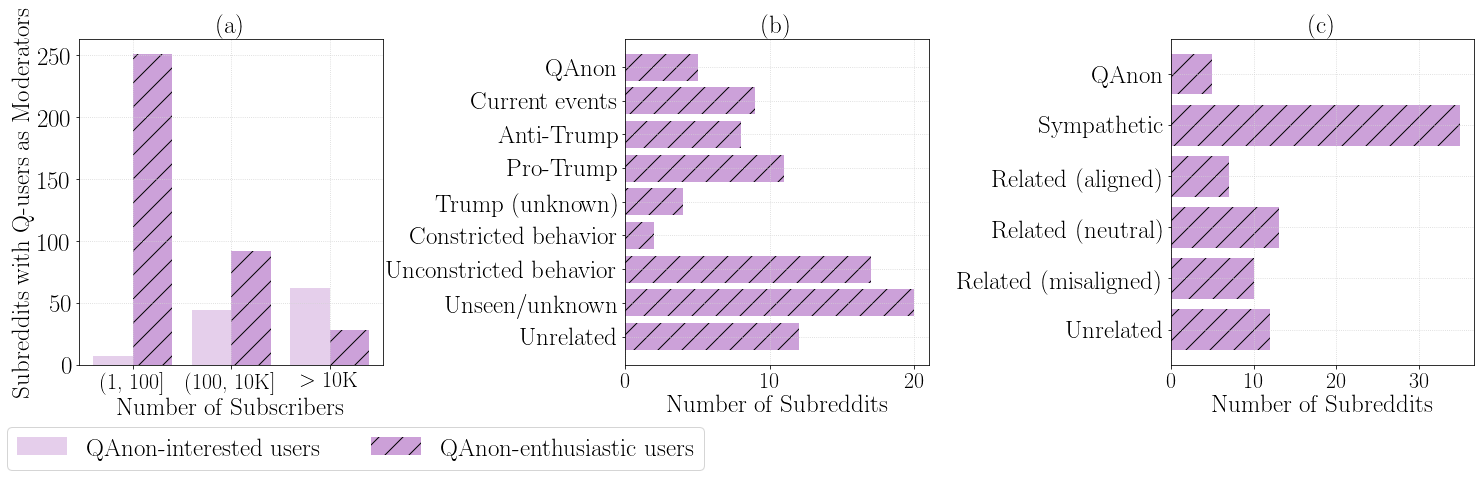

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(25, 6), gridspec_kw={'width_ratios': [1, 1, 1]})

hatches=[['', '/'], ['', '/'], ['', '/']]
titles = ['(b)', '(c)']
xlabels = ['Number of Subreddits', 'Number of Subreddits', 'Percentage of Subreddits']
alphas = [0.3, 0.6, 0.8]
plt.subplots_adjust(wspace = 0.8)

for ind in range(2):
    
  if ind == 0:
    ax = axs[1]
  else:
    ax = axs[2]
  barwidth = 0.8 / len(types[ind])
  pos_delta = -0.4 + barwidth / 2.
  for tind, t in enumerate(types[ind]):
    ax.barh(y_pos[ind] + pos_delta, height[ind][tind], barwidth, color=colors[1],
           align='center', alpha=alphas[1], ecolor='black', hatch=hatches[ind][1])
    pos_delta += barwidth
  ax.invert_yaxis()  # labels read top-to-bottom
  print(height[ind])

  vals = ax.get_xticks()
  if use_percentage[ind]:
    ax.set_xticks(vals)
    ax.set_xticklabels(['${:d}\%$'.format(int(x * 100)) for x in vals], fontsize=25)
  ax.tick_params(axis='x', labelsize=22)

  ax.set_xlabel(xlabels[ind], fontsize=25)
  #if len(labels[ind]) > 1:
  #  ax.legend(labels=labels[ind], loc='upper right', fontsize=25)
  ax.set_title(titles[ind])

  ax.set_yticks(y_pos[ind])
  ax.set_yticklabels(bar_names[ind], fontsize=25)
#axs[2].set_visible(False)

axs[0].bar(y_pos[2]-0.2, height[2][0], color=colors[1], align='center', alpha=0.3, ecolor='black', width=0.4)
axs[0].bar(y_pos[2]+0.2, height[2][1], color=colors[1], align='center', alpha=0.6, ecolor='black',
           width=0.4, hatch="/")
axs[0].tick_params(axis='y', labelsize=25)

axs[0].set_xticks(y_pos[2])
axs[0].set_xticklabels(['(1, 100]', '(100, 10K]', '$> 10$K'], fontsize=22)
axs[0].set_ylabel('Subreddits with Q-users as Moderators', fontsize=25)
axs[0].set_xlabel('Number of Subscribers', fontsize=25)

axs[0].set_title('(a)', fontsize=25)


  # Save the figure and show
  #plt.tight_layout()
for ax in [axs[0], axs[1], axs[2]]:
  ax.xaxis.grid(color="#d3d3d3", ls=":")
  ax.yaxis.grid(color="#d3d3d3", ls=":")
axs[0].legend(labels=['QAnon-interested users', 'QAnon-enthusiastic users'], 
              fontsize=25, loc='lower right', bbox_to_anchor=(2.1, -0.36), ncol=2)

# plt.savefig('figs/subreddit_mod.pdf', bbox_inches = 'tight')
plt.savefig(outputPath + 'figs/subreddit_mod.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
len(labeled)

915

### Fig. 2 Subreddits with different topic labels

In [ ]:
subreddit_label_df

,subreddit,Codes,Final Topic Clusters,Final Relation Clusters
0,2070vids,['unrelated'],['unrelated'],['unrelated']
1,3Dprinting,['unrelated'],['unrelated'],['unrelated']
2,3Dprintmything,['unrelated'],['unrelated'],['unrelated']
3,49ers,['unrelated'],['unrelated'],['unrelated']
4,4KMobileWallpapers,['unrelated'],['unrelated'],['unrelated']
...,...,...,...,...
910,xboxone,['unrelated'],['unrelated'],['unrelated']
911,yokaiwatch,['unrelated'],['unrelated'],['unrelated']
912,youngstown,['unrelated'],['unrelated'],['unrelated']
913,zen,['metaphysical/wellness'],['the unseen or unknown'],['related-aligned']


In [ ]:
sub_df

,subreddit,id,score,numReplies,author,title,text,is_self,domain,url,permalink,date_created,type
0,greatawakening,8xuv4i,1,14,879f283b831c13474e219e88663d95b0763cca9b,I’ve been writing “Trump Lives Here” on my $20...,NaN,False,i.redd.it,https://i.redd.it/h3mbbxvxq7911.jpg,/r/greatawakening/comments/8xuv4i/ive_been_wri...,2018-07-11,submission
1,greatawakening,8ydw3e,1,13,879f283b831c13474e219e88663d95b0763cca9b,Trying to take him seriously but...,NaN,False,i.redd.it,https://i.redd.it/62gaw0th4l911.jpg,/r/greatawakening/comments/8ydw3e/trying_to_ta...,2018-07-12,submission
2,greatawakening,8ytwg0,1,0,879f283b831c13474e219e88663d95b0763cca9b,“It is all happening!” Crumb?,NaN,False,i.redd.it,https://i.redd.it/yo9zscb1jx911.jpg,/r/greatawakening/comments/8ytwg0/it_is_all_ha...,2018-07-14,submission
3,greatawakening,8ytx4z,1,114,879f283b831c13474e219e88663d95b0763cca9b,“It is all happening!” Positive sign hopefully...,NaN,False,i.redd.it,https://i.redd.it/v5c4zxcjjx911.jpg,/r/greatawakening/comments/8ytx4z/it_is_all_ha...,2018-07-14,submission
4,greatawakening,8yvgwt,1,23,879f283b831c13474e219e88663d95b0763cca9b,Pedogate is REAL! Happening here in my beloved...,NaN,False,foxnews.com,http://www.foxnews.com/us/2018/07/14/texas-wom...,/r/greatawakening/comments/8yvgwt/pedogate_is_...,2018-07-14,submission
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2099870,The_Donald,dqrnbl,1161,130,c039f11ff985f7d8547748c10ccd5c8416b8404d,Imagine winning the World Series and skipping ...,NaN,False,i.redd.it,https://i.redd.it/5rveb05eocw31.png,/r/The_Donald/comments/dqrnbl/imagine_winning_...,2019-11-02,submission
2099871,The_Donald,drjrgx,34,3,c039f11ff985f7d8547748c10ccd5c8416b8404d,2A saves the day!! Again. And again. And again...,NaN,False,i.redd.it,https://i.redd.it/xxs61qz12pw31.png,/r/The_Donald/comments/drjrgx/2a_saves_the_day...,2019-11-04,submission
2099872,The_Donald,drk6ad,9,9,c039f11ff985f7d8547748c10ccd5c8416b8404d,LIBERALS CAN’T MEME: Example #97726628937,NaN,False,i.redd.it,https://i.redd.it/8o8otw7z6pw31.png,/r/The_Donald/comments/drk6ad/liberals_cant_me...,2019-11-04,submission
2099873,The_Donald,ds0yc7,35,3,c039f11ff985f7d8547748c10ccd5c8416b8404d,10 things DEMOCRATS always say INCORRECTLY!! S...,NaN,False,i.redd.it,https://i.redd.it/ofy8tjz42ww31.png,/r/The_Donald/comments/ds0yc7/10_things_democr...,2019-11-05,submission


In [ ]:
y_pos = [[], [], []]
bar_names = [[], [], []]
height = [[], [], []]
types = [[], [], []]
use_percentage = [False, True, True]
tmp_subreddit_data = {k:v for k, v in subreddit_data.items() if k in labeled_sub_topics}
labels = [['participation'], ['QAnon-interested users', 'QAnon-enthusiastic users'], ['Pre-ban', 'Post-ban']]

y_pos[0], bar_names[0], height[0], types[0] = plot_rq2(labeled_topic_new, ['participation'], subreddit_data,
         ['participation'], 'Number of Subreddits',
         'subscriber_numbers', use_percentage=False)

y_pos[1], bar_names[1], height[1], types[1] = plot_rq2(labeled_topic_new,
         ['qauth_total_submissions', 'uq_total_submissions'], tmp_subreddit_data,
         ['Q-enthusiastic', 'Q-interested'], 'Number of Mods',
         'tmp', use_percentage=True)

y_pos[2], bar_names[2], height[2], types[2] = plot_rq2(labeled_topic_new, 
         ['uq_pre_ban_submissions', 'uq_post_ban_submissions'], tmp_subreddit_data,
         ['pre ban', 'post ban'], 'Average Number of Subscribers',
         'tmp', use_percentage=True)

[[23, 40, 25, 55, 33, 11, 73, 83, 629]]
(0.0, 1.0, 0, array([[ 23.,  40.,  25.,  55.,  33.,  11.,  73.,  83., 629.]]))
[[8245.0, 38224.0, 4540.0, 219754.0, 33778.0, 4004.0, 39623.0, 34939.0, 77468.0], [25871, 81383, 12570, 406607, 42502, 2029, 235045, 139941, 85155]]
(82077.32399811488, 0.0, 8, array([[ 10533.75909546,  36930.21820058,   5282.93522463,
        193397.11222864,  23552.44295351,   1862.76728289,
         84807.32041365,  53996.47645135,  50211.96814929],
       [ 23582.24090454,  82676.78179942,  11827.06477537,
        432963.88777136,  52727.55704649,   4170.23271711,
        189860.67958635, 120883.52354865, 112411.03185071]]))
[[21184.0, 38983.0, 4680.0, 201765.0, 20728.0, 649.0, 91999.0, 68071.0, 40669.0], [4666.0, 42271.0, 7858.0, 204205.0, 21713.0, 1371.0, 142664.0, 71739.0, 44366.0]]
(20398.209862724358, 0.0, 8, array([[ 12270.64096948,  38570.16098005,   5951.61688493,
        192708.39900892,  20146.16144626,    958.86633495,
        111391.31225615,  66365.892

[[23, 40, 25, 55, 33, 11, 73, 83, 629]]
[[0.01954217507134257, 0.09059795026403861, 0.010760639760326896, 0.520857627729268, 0.0800601078908198, 0.009490220616816937, 0.09391383903599837, 0.08281189264010164, 0.1836134891966969], [0.03256577415306455, 0.10244290510219367, 0.01582280472745628, 0.5118268227380124, 0.053500465117450026, 0.0025540549556092914, 0.29586882555011623, 0.1761542654228289, 0.10719100529566743]]
[[0.053409575098390706, 0.09828481240844811, 0.011799320782688279, 0.5086944354100642, 0.05225989768879544, 0.0016362733307616864, 0.23194993860823482, 0.1716221292731568, 0.10253559335708325], [0.01176289670785109, 0.10656438206977571, 0.019809867623294872, 0.5147968971767535, 0.05473805748340564, 0.0034562647634941803, 0.35965321387245347, 0.1808526461475631, 0.1118458369782515]]


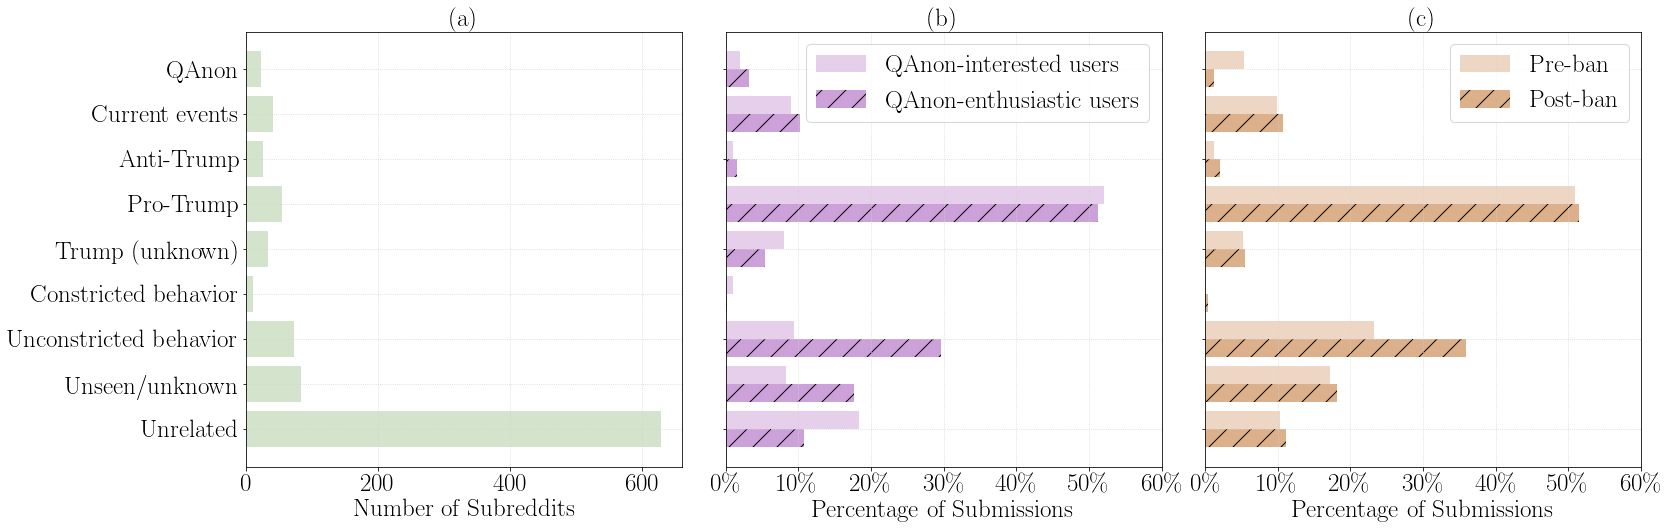

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(25, 8), gridspec_kw={'width_ratios': [1, 1, 1]})
plt.subplots_adjust(wspace = 0.1)

hatches=[[''], ['', '/'], ['', '/']]
titles = ['(a)', '(b)', '(c)']
xlabels = ['Number of Subreddits', 'Percentage of Submissions', 'Percentage of Submissions']
alphas = [0.3, 0.6, 0.8]

for ind in range(3):
  barwidth = 0.8 / len(types[ind])
  pos_delta = -0.4 + barwidth / 2.
  for tind, t in enumerate(types[ind]):
    axs[ind].barh(y_pos[ind] + pos_delta, height[ind][tind], barwidth, color=colors[ind],
           align='center', alpha=alphas[tind], ecolor='black', hatch=hatches[ind][tind])
    pos_delta += barwidth
  axs[ind].invert_yaxis()  # labels read top-to-bottom
  print(height[ind])

  vals = axs[ind].get_xticks()
  if use_percentage[ind]:
    axs[ind].set_xticks(vals)
    axs[ind].set_xticklabels(['${:d}\%$'.format(int(x * 100)) for x in vals], fontsize=25)
  axs[ind].tick_params(axis='x', labelsize=25)

  axs[ind].set_xlabel(xlabels[ind], fontsize=25)
  if len(labels[ind]) > 1:
    axs[ind].legend(labels=labels[ind], loc='upper right', fontsize=25)
  axs[ind].set_title(titles[ind])
  if ind:
    axs[ind].set_yticklabels([], fontsize=20)


axs[0].set_yticks(y_pos[ind])
axs[0].set_yticklabels(bar_names[ind], fontsize=25)

for ax in axs:
  ax.xaxis.grid(color="#d3d3d3", ls=":")
  ax.yaxis.grid(color="#d3d3d3", ls=":")

plt.savefig(outputPath + 'figs/subreddit_topic.pdf', bbox_inches = 'tight')
# plt.savefig('figs/subreddit_topic.pdf', bbox_inches = 'tight')
plt.show()

### Fig. 3 Subreddits with different relation labels

In [ ]:
8245.0+270756.0+18394.0+ 55285.0+8544.0+ 77468.0 + 25871 + 605456+155783+118463+14599+ 85155

1444019.0

In [ ]:
21184.0+ 298771.0+ 57723.0+ 56395.0+ 5329.0+ 40669.0+4666.0+ 305823.0+ 97838.0+ 61894.0+ 9229.0+ 44366.0

1003887.0

In [ ]:
y_pos = [[], [], []]
bar_names = [[], [], []]
height = [[], [], []]
types = [[], [], []]
use_percentage = [False, True, True]
tmp_subreddit_data = {k: v for k, v in subreddit_data.items() if k in labeled_sub_relation}
labels = [['participation'], ['QAnon-interested users', 'QAnon-enthusiastic users'], ['Pre-ban', 'Post-ban']]

y_pos[0], bar_names[0], height[0], types[0] = plot_rq2(labeled_relation_new, ['participation'], subreddit_data,
         ['participation'], 'Number of Subreddits',
         'subscriber_numbers', use_percentage=False)

y_pos[1], bar_names[1], height[1], types[1] = plot_rq2(labeled_relation_new,['qauth_total_submissions', 'uq_total_submissions'],
                                                       tmp_subreddit_data,
         ['Q-enthusiastic', 'Q-interested'], 'Number of Mods',
         'tmp', use_percentage=True)

y_pos[2], bar_names[2], height[2], types[2] = plot_rq2(labeled_relation_new, ['uq_pre_ban_submissions', 'uq_post_ban_submissions'],
                                                       tmp_subreddit_data,
         ['pre ban', 'post ban'], 'Average Number of Subscribers',
         'tmp', use_percentage=True)

[[23, 145, 56, 69, 36, 629]]
(0.0, 1.0, 0, array([[ 23., 145.,  56.,  69.,  36., 629.]]))
[[8245.0, 270756.0, 18394.0, 55285.0, 8544.0, 77468.0], [25871, 605456, 155783, 118463, 14599, 85155]]
(56617.7481864486, 0.0, 5, array([[ 10364.41783107, 266192.61568165,  52914.85533362,
         52784.52542245,   7030.82781875,  49404.75791247],
       [ 23751.58216893, 610019.38431835, 121262.14466638,
        120963.47457755,  16112.17218125, 113218.24208753]]))
[[21184.0, 298771.0, 57723.0, 56395.0, 5329.0, 40669.0], [4666.0, 305823.0, 97838.0, 61894.0, 9229.0, 44366.0]]
(20575.749914161355, 0.0, 5, array([[ 12361.78509135, 289124.22032958,  74391.16636733,
         56567.2416507 ,   6961.81305067,  40664.77351037],
       [ 13488.21490865, 315469.77967042,  81169.83363267,
         61721.7583493 ,   7596.18694933,  44370.22648963]]))


[[23, 145, 56, 69, 36, 629]]
[[0.01954217507134257, 0.6417418015301914, 0.04359718232410857, 0.13103567602415692, 0.020250860377143833, 0.1836134891966969], [0.03256577415306455, 0.762133019814381, 0.1960957827253239, 0.14911829088533438, 0.01837685968306557, 0.10719100529566743]]
[[0.053409575098390706, 0.7532681345223418, 0.1455325199869905, 0.14218433665378322, 0.013435594113449965, 0.10253559335708325], [0.01176289670785109, 0.7709739305368933, 0.24664772569711424, 0.15603358954902175, 0.02326613238678905, 0.1118458369782515]]


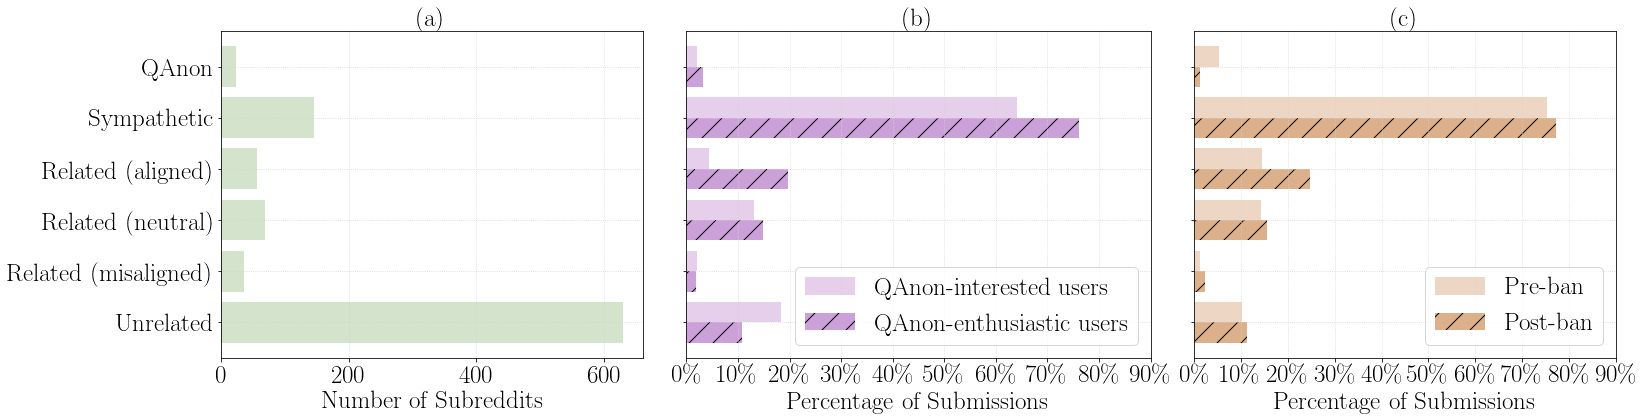

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(25, 6), gridspec_kw={'width_ratios': [1, 1.1, 1]})
plt.subplots_adjust(wspace = 0.1)

hatches=[[''], ['', '/'], ['', '/']]
titles = ['(a)', '(b)', '(c)']
xlabels = ['Number of Subreddits', 'Percentage of Submissions', 'Percentage of Submissions']
alphas = [0.3, 0.6, 0.8]

for ind in range(3):
  barwidth = 0.8 / len(types[ind])
  pos_delta = -0.4 + barwidth / 2.
  for tind, t in enumerate(types[ind]):
    axs[ind].barh(y_pos[ind] + pos_delta, height[ind][tind], barwidth, color=colors[ind],
           align='center', alpha=alphas[tind], ecolor='black', hatch=hatches[ind][tind])
    pos_delta += barwidth
  axs[ind].invert_yaxis()  # labels read top-to-bottom

  vals = axs[ind].get_xticks()
  if use_percentage[ind]:
    axs[ind].set_xticks(vals)

    axs[ind].set_xticklabels(['${:d}\%$'.format(int(x * 100)) for x in vals], fontsize=25)
  axs[ind].tick_params(axis='x', labelsize=25)

  axs[ind].set_xlabel(xlabels[ind], fontsize=25)
  if len(labels[ind]) > 1:
    axs[ind].legend(labels=labels[ind], loc='lower right', fontsize=25)
  axs[ind].set_title(titles[ind])
  print(height[ind])
  if ind:
    axs[ind].set_yticklabels([], fontsize=25)



axs[0].set_yticks(y_pos[ind])
axs[0].set_yticklabels(bar_names[ind], fontsize=25)

for ax in axs:
  ax.xaxis.grid(color="#d3d3d3", ls=":")
  ax.yaxis.grid(color="#d3d3d3", ls=":")

plt.savefig(outputPath + 'figs/subreddit_relation.pdf', bbox_inches = 'tight')
# plt.savefig('figs/subreddit_relation.pdf', bbox_inches = 'tight')
plt.show()

## QANON-ENTHUSIASTIC USERS’ ACTIVITIES IN OTHER COMMUNITIES

### Fig. 5 Types of submissions in subreddits

In [ ]:
submission_df= []
# datadir = "/data/yiqing/QReddit/RQ3_Labelling Results"
datadir = inputPath + "RQ3_LabellingResults"
for filename in os.listdir(datadir):
    with open(os.path.join(datadir, filename), "r") as r:
        tmp = pd.read_csv(r)
    submission_df.append(tmp)

In [ ]:
submission_df = pd.concat(submission_df)

In [ ]:
len(submission_df)

1571

In [ ]:
submission_df.subreddit.nunique()

233

In [ ]:
def plot_rq3(labeled, types, subreddit_data, totalcnt, use_percentage=True):
  bar_names = list(labeled.keys())
  height = [[] for t in types]
  yerr = [[] for t in types]
  total = {}
  
  for bind, b in enumerate(bar_names):
    total[bind] = 0
    for subreddit in labeled[b]:
      if subreddit not in totalcnt:
        continue
      total[bind] += totalcnt[subreddit] 
    #print(b, total[bind])
    for tind, t in enumerate(types):
      tmp = 0
      for subreddit in labeled[b]:
          if subreddit not in subreddit_data:
            continue
          tmp = tmp + subreddit_data[subreddit][t]
      height[tind].append(tmp)
  #print(height)
  print(chi2_contingency(height))
  for tind, t in enumerate(types):
    if use_percentage:
      height[tind] = [h / total[bind] for bind, h in enumerate(height[tind])]
  y_pos = np.arange(len(bar_names))
  return y_pos, bar_names, height, types

In [ ]:
submission_data = {}
total = defaultdict(int)
labels = set()
for _, row in submission_df.iterrows():
    if row['subreddit'] not in submission_data:
        submission_data[row['subreddit']] = defaultdict(int)
    for entryind in range(1, 5):
        entry = 'Reconcile Code{}'.format(entryind)
        if type(row[entry]) is str:
          submission_data[row['subreddit']][row[entry]] += 1
          labels.add(row[entry])
    total[row['subreddit']] += 1

In [ ]:
labels

{'Conspiracy-Other',
 'Conspiracy-Politics',
 'Hate Speech',
 'Low-quality Source',
 'Negative Interaction',
 'QAnon',
 'Unrelated'}

In [ ]:
submission_data['CoincidenceTheorist'].keys()

dict_keys(['Conspiracy-Politics', 'Unrelated', 'Conspiracy-Other', 'QAnon', 'Low-quality Source', 'Negative Interaction'])

In [ ]:
y_pos = [[], [], [], []]
bar_names = [[], [], [], []]
height = [[], [], [], []]
types = [[], [], [], []]
use_percentage = [True, True, True, True]
labels = [['Conspiracy-Other',
 'Conspiracy-Politics',
 'Negative Interaction','Hate Speech', 'Low-quality Source', 
 'QAnon', 'Unrelated'], ['Conspiracy-Other',
 'QAnon'], ['Conspiracy-Other',
 'Conspiracy-Politics',
 'Negative Interaction','Hate Speech','Low-quality Source',
 'QAnon']]

y_pos[0], bar_names[0], height[0], types[0] = plot_rq3(labeled_relation_new, labels[0], submission_data,
                                                       total, use_percentage=True)

y_pos[1], bar_names[1], height[1], types[1] = plot_rq3(labeled_topic_new, labels[0], submission_data,
                                                       total, use_percentage=True)

(897.2245330737379, 2.3425718910858582e-169, 30, array([[  9.44173192,  22.83740212,  11.69138646,  12.64578535,
          8.82818977,   8.55550438],
       [ 14.67296177,  35.49055735,  18.16904652,  19.65223399,
         13.71948411,  13.29571626],
       [ 17.35237218,  41.97144173,  21.48687241,  23.24090281,
         16.22478121,  15.72362966],
       [  1.65868263,   4.01197605,   2.05389222,   2.22155689,
          1.5508982 ,   1.50299401],
       [103.60386918, 250.59419622, 128.28926762, 138.76186089,
         96.87148779,  93.87931829],
       [ 18.75587287,  45.3661907 ,  23.22478121,  25.12068171,
         17.53707969,  16.99539383],
       [111.51450944, 269.72823584, 138.08475357, 149.35697835,
        104.26807923, 101.04744357]]))
(1086.0509606131359, 4.722364781425742e-196, 48, array([[  8.87978629,   8.81567231,   6.15494212,  13.11130899,
          4.77649154,   2.14781834,  15.80409617,   4.2635797 ,
          8.04630454],
       [ 14.67631345,  14.57034728,  10.17

In [ ]:
height[0]

[[0.11952191235059761,
  0.02821316614420063,
  0.0425531914893617,
  0.01662049861495845,
  0.01968503937007874,
  0.004],
 [0.12350597609561753,
  0.050156739811912224,
  0.04559270516717325,
  0.038781163434903045,
  0.08661417322834646,
  0.004],
 [0.08764940239043825,
  0.08150470219435736,
  0.0547112462006079,
  0.055401662049861494,
  0.07874015748031496,
  0.016],
 [0.01593625498007968,
  0.007836990595611285,
  0.0060790273556231,
  0.002770083102493075,
  0.003937007874015748,
  0.0],
 [0.13147410358565736,
  0.5532915360501567,
  0.6474164133738601,
  0.42382271468144045,
  0.1732283464566929,
  0.064],
 [0.3426294820717131,
  0.047021943573667714,
  0.030395136778115502,
  0.0332409972299169,
  0.015748031496062992,
  0.02],
 [0.28286852589641437,
  0.28213166144200624,
  0.21580547112462006,
  0.45706371191135736,
  0.6417322834645669,
  0.896]]

In [ ]:
bar_names_new = [['QAnon',
 'Sympathetic',      
 'Related\n(aligned)',
 'Related\n(neutral)',
 'Related\n(misaligned)',
 'Unrelated'],
 ['QAnon',
 'Current\nevents',
 'Anti-\nTrump',
 'Pro-\nTrump',
 'Trump\nunknown',
 'Constricted\nbehavior',
 'Unconstricted\nbehavior',
 'Unseen\n/unknown',
 'Unrelated']]

[[0.11952191235059761, 0.02821316614420063, 0.0425531914893617, 0.01662049861495845, 0.01968503937007874, 0.004], [0.12350597609561753, 0.050156739811912224, 0.04559270516717325, 0.038781163434903045, 0.08661417322834646, 0.004], [0.08764940239043825, 0.08150470219435736, 0.0547112462006079, 0.055401662049861494, 0.07874015748031496, 0.016], [0.01593625498007968, 0.007836990595611285, 0.0060790273556231, 0.002770083102493075, 0.003937007874015748, 0.0], [0.13147410358565736, 0.5532915360501567, 0.6474164133738601, 0.42382271468144045, 0.1732283464566929, 0.064], [0.3426294820717131, 0.047021943573667714, 0.030395136778115502, 0.0332409972299169, 0.015748031496062992, 0.02], [0.28286852589641437, 0.28213166144200624, 0.21580547112462006, 0.45706371191135736, 0.6417322834645669, 0.896]]
[[0.11952191235059761, 0.014814814814814815, 0.0213903743315508, 0.012919896640826873, 0.013888888888888888, 0.014925373134328358, 0.02127659574468085, 0.11627906976744186, 0.004], [0.12350597609561753, 0

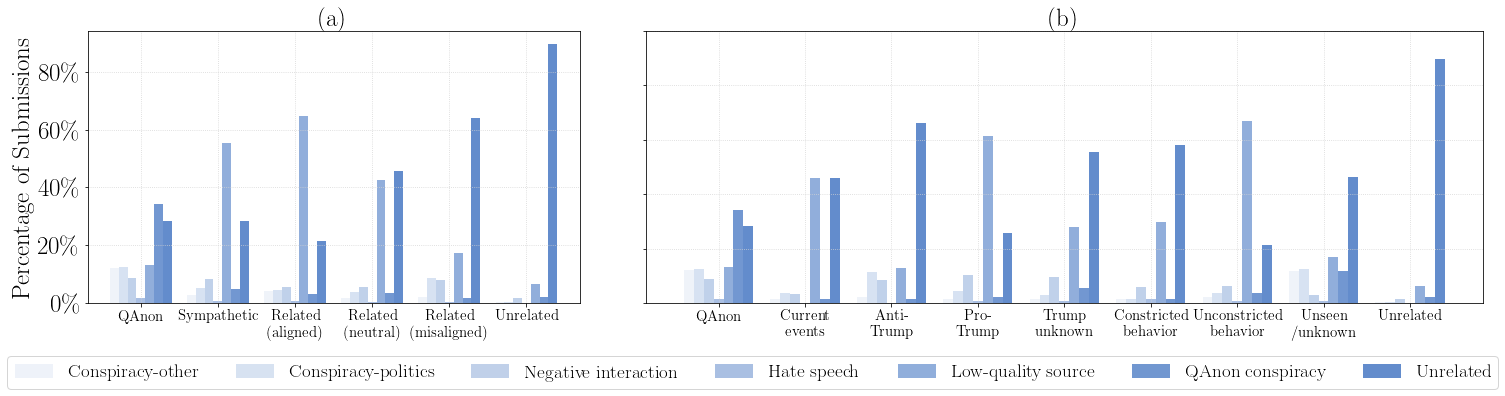

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(25, 5), gridspec_kw={'width_ratios': [1,1.7]}, sharey=True)
plt.subplots_adjust(wspace = 0.1)

#hatches=[['', '-', '/', '+'], ['', '-', '/', '+']]
titles = ['(a)', '(b)', '(c)']
xlabels = ['Number of Subreddits', 'Percentage of Submissions', 'Percentage of Submissions']
alphas = [0.1, 0.25, 0.4, 0.55, 0.7, 0.9, 1]

for ind in range(2):
  barwidth = 0.8 / len(types[ind])
  pos_delta = -0.4 + barwidth / 2.
  for tind, t in enumerate(types[ind]):
    axs[ind].bar(y_pos[ind] + pos_delta, height[ind][tind], barwidth, color=colors[3],
           align='center', alpha=alphas[tind], ecolor='black')#, hatch=hatches[ind][tind])
    pos_delta += barwidth
  #axs[ind].invert_yaxis()  # labels read top-to-bottom

  vals = axs[ind].get_yticks()
  if use_percentage[ind]:
    axs[ind].set_yticks(vals)

    axs[ind].set_yticklabels(['${:d}\%$'.format(int(x * 100)) for x in vals], fontsize=25)
  axs[ind].tick_params(axis='y', labelsize=25)

  #if len(labels[ind]) > 1:
  #  axs[ind].legend(labels=labels[ind], loc='upper right', fontsize=25)
  axs[ind].set_title(titles[ind])
  print(height[ind])

  axs[ind].set_xticks(y_pos[ind])
  axs[ind].set_xticklabels(bar_names_new[ind], fontsize=15)
axs[0].set_ylabel('Percentage of Submissions', fontsize=25)
axs[1].legend(labels=['Conspiracy-other',
 'Conspiracy-politics',
 'Negative interaction', 'Hate speech', 'Low-quality source', 
 'QAnon conspiracy', 'Unrelated'], loc='upper right', fontsize=19, ncol=7, bbox_to_anchor=(1.03, -0.16))
for ax in axs:
  ax.xaxis.grid(color="#d3d3d3", ls=":")
  ax.yaxis.grid(color="#d3d3d3", ls=":")
plt.savefig(outputPath + 'figs/subreddit_submission.pdf', bbox_inches = 'tight')
# plt.savefig('figs/subreddit_submission.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
count = 0

for subreddit, values in submission_data.items():
    count += values["Hate Speech"]
    # for label in values.keys():
    #     count += values[label]

In [ ]:
count

10

In [ ]:
10/1571

0.006365372374283896